In [3]:
import os
import pandas as pd
import numpy as np
from glob import glob
import gspread
import h3
from tqdm import tqdm
from fcmeans import FCM
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import NMF
from sklearn.metrics import silhouette_score, silhouette_samples
import seaborn as sns
import os

In [4]:
DATA_FOLDER = "/group/geog_pyloo/08_GSV/data/_curated/c_seg_hex"
GRAPHIC_PATH = "/group/geog_pyloo/08_GSV/_graphic/cluster"
if not os.path.exists(GRAPHIC_PATH):
       os.makedirs(GRAPHIC_PATH)

In [34]:

FILES = os.listdir(DATA_FOLDER)
RES = 9
FILENMAE = "c_seg_cat=31_res={res}.parquet"
df = pd.read_parquet(os.path.join(DATA_FOLDER, FILENMAE.format(res = RES)))

variables = ['bike', 
             'building', 
             'bus', 
             'car',
       'grass', 
       'house', 
       'installation', 
       'lake+waterboday', 
       'light',
       'mountain+hill', 
       'person', 
       'pole', 
       'railing', 
       'road',
       'shrub', 
       'sidewalk', 
       'signage', 
       'sky',  
       'sportsfield',
       'table+chair', 
       'tower', 
       'traffic light', 
       'trashcan', 
       'tree', 
       'truck',
       'van', 
       'wall',
       'skyscraper',
       'window']
index_cols = ['city_lower', 'hex_id', 'img_count',  "res"]
variable_mapping_2 = dict(zip(
       ['bike', 
             'building', 
             'bus', 
             'car',
       'grass', 
       'house', 
       'installation', 
       'lake+waterboday', 
       'light',
       'mountain+hill', 
       'person', 
       'pole', 
       'railing', 
       'road',
       'shrub', 
       'sidewalk', 
       'signage', 
       'sky',  
       'sportsfield',
       'table+chair', 
       'tower', 
       'traffic light', 
       'trashcan', 
       'tree', 
       'truck',
       'van', 
       'wall',
       'ground',
       'other',
       'skyscraper',
       'window'],
       ['bike', 
             'building', 
             'bus', 
             'car',
       'grass', 
       'house', 
       'furniture', 
       'nature', 
       'furniture', 
       'nature',  
       'person', 
       'furniture', 
       'railing', 
       'road',
       'shrub', 
       'sidewalk', 
       'signage', 
       'sky',  
       'sportsfield',
       'furniture', 
       'tower', 
       'furniture', 
       'furniture', 
       'tree', 
       'truck',
       'van', 
       'wall',
       'other',
       'other',
       'skyscraper',
       'building',])
)

In [22]:
# check for nan values per variable
df[variables].isna().sum().sort_values()

category
bike               0
van                0
truck              0
tree               0
trashcan           0
traffic light      0
tower              0
table+chair        0
sportsfield        0
sky                0
signage            0
sidewalk           0
shrub              0
wall               0
road               0
pole               0
person             0
other              0
mountain+hill      0
light              0
lake+waterboday    0
installation       0
house              0
grass              0
car                0
bus                0
building           0
railing            0
window             0
dtype: int64

In [7]:
def get_std(df_seg_update, variables_remain):
    scaler = StandardScaler().fit(df_seg_update[variables_remain])
    data = scaler.transform(df_seg_update[variables_remain])
    return data
    
def get_tsne(data, n_components = 2):
        
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

def inertia_array(fcm, data):
    """
    It is calculated by measuring the distance between each data point and its centroid, 
    squaring this distance, and summing these squares across one cluster. 
    A good model is one with low inertia AND a low number of clusters ( K ). """
    dist = 0
    prediction = fcm.predict(data)
    centers = fcm.centers
    for idx in range(len(prediction)):
        center = centers[prediction[idx],:]
        dist += ((center - data[idx,:]) ** 2).sum()
    return dist

def construct_vec(arr, log10):
    #Construct vector: pattern only
    if arr.sum() != 0:
        if log10:
            arr = np.log10(arr + 1)
        pattern = arr / arr.sum()
        return pattern
    else:
        return np.zeros(arr.shape[0])

def f_cmeans(pattern_df, n_clusters, log10, random_state):
    '''
    input: 
    pattern_df: dictionary of ID-Pattern pairs
    beta: beta value to balance volume and pattern
    n_clusters: number of clusters
    vector_mode: 1 or 2, 1 means construct vector from paper, 2 means our own method
    output:
    ndarry, cluster result for each id
    '''
    # construct vector
    data = np.zeros(pattern_df.shape)
    if type(pattern_df) == pd.core.frame.DataFrame:
        for count, idx in enumerate(pattern_df.index):
            data[count, :] = construct_vec(pattern_df.iloc[count], log10)
    elif type(pattern_df) == np.ndarray:
        for count in range(pattern_df.shape[0]):
            data[count, :] = construct_vec(pattern_df[count, :], log10)
    
    fcm = FCM(n_clusters=n_clusters, random_state=random_state)
    fcm.fit(data)
    
    return fcm, data

def remapping(df):
    df_long = df.set_index(index_cols, inplace = True).stack().reset_index()
    

In [26]:
df_long = df.set_index(index_cols).stack().reset_index()
df_long.head()

,city_lower,hex_id,img_count,res,category,0
0,accra,8975292c127ffff,20,9.0,bike,28.70
1,accra,8975292c127ffff,20,9.0,building,15701.50
2,accra,8975292c127ffff,20,9.0,bus,25.10
3,accra,8975292c127ffff,20,9.0,car,4789.85
4,accra,8975292c127ffff,20,9.0,grass,213.30


In [28]:
df_long.rename(columns = {0:'value'}, inplace = True)

In [36]:
df_long['category_2'] = df_long['category'].apply(lambda x: variable_mapping_2[x])
print(df_long['category_2'].nunique())

23


In [37]:
df_long_summ = df_long.groupby(index_cols + ['category_2'])['value'].sum().unstack().reset_index()
df_long_summ.shape

(567073, 27)

In [38]:
import gc
gc.collect()

71

In [ ]:
df_wide = df_long.pivot_table(index = ['city_lower', 'hex_id', 'img_count', 'res'], 
                              columns = 'category_2', values = 'value').reset_index()

In [5]:
# standardize the data
data = get_std(df, variables)
print("finish basic standardization")
# get tsne
tsne_data = get_tsne(data) # this takes very long time.
print("finish tsne")
# save the tsne_data once done
tsne_df = pd.DataFrame(
    tsne_data,
    columns = ["tsne_1", "tsne_2"]
)
tsne_df = pd.concat([df[index_cols], tsne_df], axis = 1)
tsne_df.to_parquet(os.path.join(DATA_FOLDER, FILENMAE.replace(".parquet", "").format(res = RES) + "_tsne.parquet"))

finish basic standardization


In [12]:
def plot_wss(data, N, comment):
    wss = []
    for i in range(2,N):
        print("cluster: ", i)
        fcm_vol = FCM(n_clusters=i, random_state=0)
        fcm_vol.fit(data)
        wss.append(inertia_array(fcm_vol, data))
    sns.set(style="whitegrid")
    sns.set_context("paper", rc={"font.size":10,"axes.titlesize":12,"axes.labelsize":12})

    plt.figure(figsize=(6,4))
    plt.plot(range(2,N), wss, 'bx-', color='black')
    # plt.grid(True,alpha=.3)
    # plt.legend(framealpha=.3)
    plt.xlabel('Number of clusters $c$')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method showing the optimal $c$')
    plt.savefig(os.path.join(GRAPHIC_PATH,f"elbow_volume_{N}_{comment}.png"), dpi=200, bbox_inches = 'tight')
    plt.show()

finish basic standardization
cluster:  2
cluster:  3
cluster:  4
cluster:  5
cluster:  6
cluster:  7
cluster:  8
cluster:  9
cluster:  10
cluster:  11
cluster:  12
cluster:  13
cluster:  14
cluster:  15
cluster:  16
cluster:  17
cluster:  18
cluster:  19
cluster:  20
cluster:  21
cluster:  22
cluster:  23
cluster:  24
cluster:  25
cluster:  26
cluster:  27
cluster:  28
cluster:  29


/tmp/ipykernel_1545321/3777347026.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(range(2,N), wss, 'bx-', color='black')


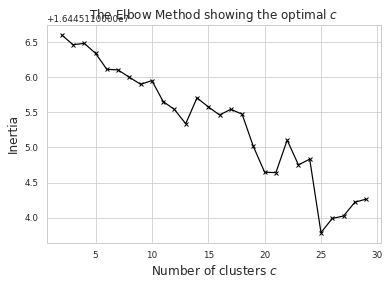

In [13]:
# standardize the data
data = get_std(df, variables)
print("finish basic standardization")
comment= "3-variables"
N = 30
plot_wss(data, N, comment)

In [14]:
# Select N
n = 20
fcm_pattern, data_pattern = f_cmeans(data, n_clusters=n, log10 = False,  random_state=0)
prediction_pattern = fcm_pattern.predict(data)

df["class"] = prediction_pattern
data_des = pd.DataFrame(data, columns = variables)
data_des["class"] = prediction_pattern

In [16]:
data_des.groupby("class").size()

class
0         17
1         79
2         12
3       1043
7         14
12    324706
18    241202
dtype: int64

In [17]:
# visualize one city
# get the geometry
from shapely.geometry import Polygon
import geopandas as gpd

def cell_to_shapely(cell):
    coords = h3.h3_to_geo_boundary(cell)
    flipped = tuple(coord[::-1] for coord in coords)
    return Polygon(flipped)

city = "London"
cityabbr = city.lower().replace(" ", "")
sample = df[df["city_lower"]==cityabbr].reset_index(drop = True)
h3_geoms = sample['hex_id'].apply(lambda x: cell_to_shapely(x))
df_sel_gdf = gpd.GeoDataFrame(sample[['hex_id',"class"]], geometry = h3_geoms)
df_sel_gdf.crs = "EPSG:4326"
df_sel_gdf['class'] = df_sel_gdf['class'].astype(str)

<AxesSubplot:>

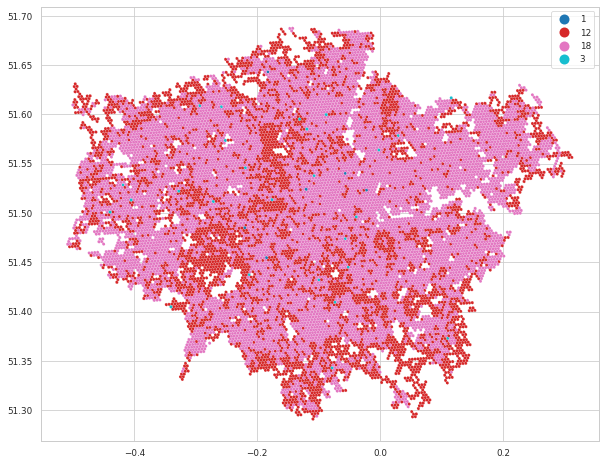

In [18]:
df_sel_gdf.plot(figsize = (10,10), column = "class", legend = True, linewidth = 0.1)

In [15]:
def plot_wss_kmean(data, N, comment):
    """Try Kmean instead"""
    wss = []
    for i in range(2,N):
        print("cluster: ", i)
        # fcm_vol = FCM(n_clusters=i, random_state=0)
        kmeans = KMeans(n_clusters=i, random_state=0)
        kmeans.fit(data)
        wss.append(inertia_array(fcm_vol, data))
    sns.set(style="whitegrid")
    sns.set_context("paper", rc={"font.size":10,"axes.titlesize":12,"axes.labelsize":12})

    plt.figure(figsize=(6,4))
    plt.plot(range(2,N), wss, 'bx-', color='black')
    # plt.grid(True,alpha=.3)
    # plt.legend(framealpha=.3)
    plt.xlabel('Number of clusters $c$')
    plt.ylabel('Inertia')
    plt.title('The Elbow Method showing the optimal $c$')
    plt.savefig(os.path.join(GRAPHIC_PATH,f"elbow_volume_{N}_{comment}.png"), dpi=200, bbox_inches = 'tight')
    plt.show()

In [ ]:
comment= "31-variables-kmean"
N = 30
plot_wss(data, N, comment)